# The evolution of language in films

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf

from pyspark.sql import *
%matplotlib inline

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

sqlContext = SQLContext(sc)

/home/rinjac/anaconda3/envs/ada/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/rinjac/anaconda3/envs/ada/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 0. Extraction of data

###  <font color='red'>NOTE:</font> All of the extraction of data has been done in the cluster. We have included the scripts in the notebook for the purpose of documentation.

Each subtitle in the OpenSubtitle database is stored in a seperate XML-file. In order to analyse the data and we need to convert it to a format more appropriate for Spark/Pandas. Instead of having ~180000 different XML-files, we would like to have the data stored in a dataframe.

In order to process the dataset using Spark, we will use the spark-xml package from databricks (https://github.com/databricks/spark-xml).

When using spark-xml, you can either let spark-xml infer the schema of the XML file or you can specify it yourself. Delegating the job of creating the schema to spark-xml is convenient however it is very expensive which we experienced through first hand experience. In order to speed up our input pipeline, we will specify or own static xml schema below. When specifying the schema yourself, spark-xml will not try to infer the schema which gives a significant performance boost when reading large numbers of XML-files.

## 0.1 schema

We will extract 2 seperate dataframes, therefore we will need two different XML schemas. One schema will be used to extract the movie meta data contained in each subtitle file and the other schema will be used to extract the actual subtitle text.

### 0.1.1 meta data schema

In [2]:
# Schema for the source XML-tag
sourceSchema = StructType([\
                            StructField('genre', StringType()),
                            StructField('year', StringType()),
                          ])

# Schema for the source XML-tag
subtitleSchema = StructType([\
                            StructField('duration', StringType())
                          ])

# Schema for the conversion XML-tag
conversionSchema =  StructType([\
                                StructField('sentences', StringType()),
                                StructField('tokens', StringType())
                              ])

# Schema for the meta XML-tag
mSchema = StructType([\
                        StructField('source', sourceSchema),
                        StructField('conversion', conversionSchema),
                        StructField('subtitle', subtitleSchema),
                    ])

# Root schema
metaSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('meta', mSchema)
])

### 0.1.1 subtitle data schema

The schema will produce a dataframe with two columns. One column will contain the movie id and a column **s** which is of type Array. The elements of the Array in column **s** holds elements which also are arrays. Each nested array represents a sentence and each element of the nested Arrays are the words of the sentence.

In [3]:
# Schema for the w (word) XML-tag
wordSchema = ArrayType(StructType([\
                                StructField('_VALUE', StringType())\
                               ]))

# Schema for the s (sentence) XML-tag
sentenceSchema = StructType([StructField('w', wordSchema)])

# Root schema
sentenceSchema = StructType([
    StructField('_id', IntegerType()),
    StructField('s', ArrayType(sentenceSchema))
])

## 0.2 Parsing of xml-data

The OpenSubtitle dataset uses the following folder structure:

**opensubtitle/OpenSubtitles2018/xml/ { language } / { year } / { imdb_id } / { openSubtitle_id }.xml.gz**

* **year:** the release year of the movie
* **langauge:** the language of the movie
* **imdb_id:** id of the movie in the IMDB database
* **openSubtitle_id:** unique identifier in the opensubtitle database

With the help of regular expression we can load every single subtitle file at once using spark. 

### 0.2.1 meta data dataframe

**The meta data we extract for each movie is the following:**

* **_id**: the openSubtitle id - **type**: string
* **year**: the release year of the movie - **type**: numeric
* **sentences**: the total amount of sentences in the movie - **type**: numeric
* **words**: the total amount of words in the movie (not unique words) - **type**: numeric
* **duration**:: the duration of the movie - **type**: string
* **imdb_id**: id of the movie in the IMDB database - **type**: string

The imdb_id is actually not contained in the XML-file of each movie but the parent directory of each XML subtitle file is named using the imdb identifier. Therefore, we extract the imdb_id from the file path of each subtitle file.

In [7]:
# Loads all subtitles files in english and parses the input files with the schema for meta data.
df_metadata = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', 
             samplingRatio=0.0)\
    .load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[1-2][0-9][0-9][0-9]/**/*.xml.gz', 
          schema=metaSchema)

In [60]:
movies_meta = df_metadata.select(\
               F.col("_id"),\
               F.col("meta.source.genre").alias("genre"),\
               F.col("meta.source.year").alias("year"),\
               F.col("meta.conversion.sentences").alias("sentences"),\
               F.col("meta.conversion.tokens").alias("words"),\
               F.col("meta.subtitle.duration").alias("duration"))  

movies_meta = movies.withColumn("imdb_id",F.split(F.input_file_name(), "/").getItem(6))

In [ ]:
movies_meta.write.mode("overwrite").parquet('movie_data_with_imdb_id.parquet')

### 0.2.1 subtitle dataframe

The subtitle dataframe has the following structure:

* **_id:** the openSubtitle id - **type**: string
* **sentence:** a sentence belonging to the movie identified by the **_id** field - **type**: List of List(String)

In [ ]:
# Loads all subtitles files in english and parses the input files with the schema for subtitle data.
df_subtitle = sqlContext.read.format('com.databricks.spark.xml')\
    .options(rowTag='document', 
             samplingRatio=0.0)\
    .load('hdfs:///datasets/opensubtitle/OpenSubtitles2018/xml/en/[1-2][0-9][0-9][0-9]/**/*.xml.gz', 
          schema=sentenceSchema)

In [ ]:
# The tag s.w in the nested XML-structure holds an array of sentences for each movie.
# We want each movie to have its own entry in the dataframe, we use the explode function to create one row
# in the dataframe for each nested array contained in the s.w tag
movies_subtitle = df.select('_id',
                            F.explode(F.col('s.w')).alias('sentence'))

In [ ]:
movies_subtitle.write.mode("overwrite").parquet('movies_subtitle.parquet')

## 0.3 Enriching the dataset

With the help of the imdb_id, we can enrich our dataset with one or several of IMDBs public datasets (https://www.imdb.com/interfaces/). We are interested in the imdb rating of each movie, let's add it to our existing movies dataframe by joining it with the ratings dataset of IMDB.

In [18]:
movies = spark.read.parquet("./movie_data_with_imdb_id.parquet")
movies.show(3)

+-------+--------------------+----+---------+-----+------------+-------+
|    _id|               genre|year|sentences|words|    duration|imdb_id|
+-------+--------------------+----+---------+-----+------------+-------+
|7018237|Comedy,Drama,Romance|1947|     2768|20350|01:55:25,969|  39477|
|3528271| Crime,Drama,Fantasy|1993|     1557|10885|01:56:41,202| 107665|
|4655639|Animation,Comedy,...|1935|      142|  457|00:15:15,010|  26706|
+-------+--------------------+----+---------+-----+------------+-------+
only showing top 3 rows



In [19]:
imdb_ratings = spark.read.format("csv")\
                        .option("header", "true")\
                        .option("sep", "\t").load("title.ratings.tsv")
imdb_ratings.show(3)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1437|
|tt0000002|          6.3|     171|
|tt0000003|          6.6|    1037|
+---------+-------------+--------+
only showing top 3 rows



The imdb ids in the IMDB dataset has a few minor differences compared to the imdb ids in the OpenSubtitle dataset. 

1. The id's in the IMDB dataset are prefixed with the string "tt"
2. The id's in the OpenSubtitle dataset has stripped away leading zeros in the imdb id

Let's define a simple spark UDF which will take care of both inconsistencies:

In [20]:
remove_prefix_and_leading_zeros = F.udf(lambda x: x[2:].lstrip('0'), StringType())

In [21]:
remove_prefix = F.udf(lambda x: x[2:], StringType())
imdb_ratings = imdb_ratings.select('averageRating', 
                                   'numVotes', 
                                   remove_prefix_and_leading_zeros(F.col('tconst')).alias('id'))
# we do a left outer join since we still want to keep movies from our original dataset that 
# does not match any movies in the imdb dataset.
movies = movies.join(imdb_ratings, movies.imdb_id == imdb_ratings.id, "left_outer")\
     .select('_id', 'genre', 'year', 'sentences', 'words', 'duration', 'numVotes', 'averageRating', 'imdb_id')
movies.show(3)

+-------+--------------------+----+---------+-----+------------+--------+-------------+-------+
|    _id|               genre|year|sentences|words|    duration|numVotes|averageRating|imdb_id|
+-------+--------------------+----+---------+-----+------------+--------+-------------+-------+
|4579146|Comedy,Drama,Romance|1990|     1332| 9373|01:39:48,845|   25410|          6.6| 100140|
|3678600|Comedy,Drama,Romance|1990|     1344| 9365|01:41:20,585|   25410|          6.6| 100140|
|6325233|Comedy,Drama,Romance|1990|     2066|15353|01:50:03,583|   25410|          6.6| 100140|
+-------+--------------------+----+---------+-----+------------+--------+-------------+-------+
only showing top 3 rows



In [22]:
movies.write.mode("overwrite").parquet('movie_data_with_ratings.parquet')

# 1. Descriptive statistics

## 1.1 Meta data dataframe

Before working with our data, let's get to know it. We will start by getting the movie data.

In [2]:
movies = spark.read.parquet("./datasets/movie_data_with_ratings.parquet")
print("There are " + str(movies.count()) + " entries in the dataset.")

There are 177039 entries in the dataset.


What information do we have for every movie?

In [3]:
movies.schema

StructType(List(StructField(_id,IntegerType,true),StructField(genre,StringType,true),StructField(year,StringType,true),StructField(sentences,StringType,true),StructField(words,StringType,true),StructField(duration,StringType,true),StructField(numVotes,StringType,true),StructField(averageRating,StringType,true),StructField(imdb_id,StringType,true)))

In [4]:
# convert to DF format
movies = movies.toDF('id', 
                     'genre', 
                     'year', 
                     'sentences', 
                     'words', 
                     'duration', 
                     'numVotes', 
                     'averageRating', 
                     'imdb_id')

# number of words, sentences, numVotes and year are ints 
movies = movies.withColumn("words", movies["words"].cast("int"))
movies = movies.withColumn("sentences", movies["sentences"].cast("int"))
movies = movies.withColumn("numVotes", movies["numVotes"].cast("int"))
movies = movies.withColumn("year", movies["year"].cast("int"))

# AverageRating is a float
movies = movies.withColumn("averageRating", movies["averageRating"].cast("float"))


# convert duration to minutes
@udf('string')
def convert_duration(duration):
    try:
        return str(int(duration[:2]) * 60 + int(duration[3:5])) 
    except: 
        return "0"

movies = movies.withColumn("duration", convert_duration(movies.duration))
movies = movies.withColumn("duration", movies["duration"].cast("int"))

movies.printSchema()

root
 |-- id: integer (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- sentences: integer (nullable = true)
 |-- words: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- numVotes: integer (nullable = true)
 |-- averageRating: float (nullable = true)
 |-- imdb_id: string (nullable = true)



Our dataset contains a lot of TV series along with the movies. We can say that almost all TV series are less than 60 minutes long, while almost all movies are longer than 60 minutes.

Considering we want __only__ films in our dataset, we will remove all entries which have a duration of less than 60 minutes. This should remove the great majority of TV series and keep the great majority of films in our dataset.

In [5]:
movies = movies.filter(movies.duration > 60)
print("We are left with " + str(movies.count()) + " films after removing the TV series.")

We are left with 74674 films after removing the TV series.


### 1.1.1 Number of movies by year

So how many movies are there for each year? We presume there will be more movies in recent years than 1950. 

Firstly, we check the range of the years.

In [7]:
movies.describe('year').show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|             74416|
|   mean|1995.3661175016125|
| stddev|21.925659193233678|
|    min|              1896|
|    max|              2017|
+-------+------------------+



Now let's draw a chart showing exactly how many movies were there for each year.

In [8]:
# get movie counts per year
movies_per_year = movies.groupby('year').count()

# convert to Pandas for plotting
ydf = movies_per_year.toPandas()

# sort the films by year
ydf = ydf.sort_values(by='year')

We need to clean our data of null values and inconsistent entries.

In [9]:
n_before = sum(ydf['count'])
print("Before cleaning we have " + str(n_before) + " films. ")

# convert year to int the 'year' value
ydf['year'] = pd.to_numeric(ydf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ydf = ydf.dropna()
ydf = ydf.reset_index(drop=True)
ydf['year'] = ydf['year'].astype('int')

n_after = sum(ydf['count'])
print("After cleaning we have " + str(n_after) + " films. ")
print("Only %.5f%% of our dataset was invalid/inconsistent." % (1 - (n_after/n_before)))

Before cleaning we have 74674 films. 
After cleaning we have 74416 films. 
Only 0.00346% of our dataset was invalid/inconsistent.


To plot the number of films by year, we will bin them to make the visualization clearer.

Considering we have movies from 1896 to 2020, we are going to make 13 bins for each decade from 1890s to 2010s (We are going to put year 2020 in 2010s, it will not change much because we have only  6 films for 2020)

In [10]:
years = list(ydf['year'])
labels = []
counts = []

for decade in range(1890, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            count += int(ydf.loc[ydf['year'] == year]['count'])
    counts.append(count)

# add the 2020 to the 2010s decade
counts[11] += int(ydf.loc[ydf['year'] == 2010]['count'])

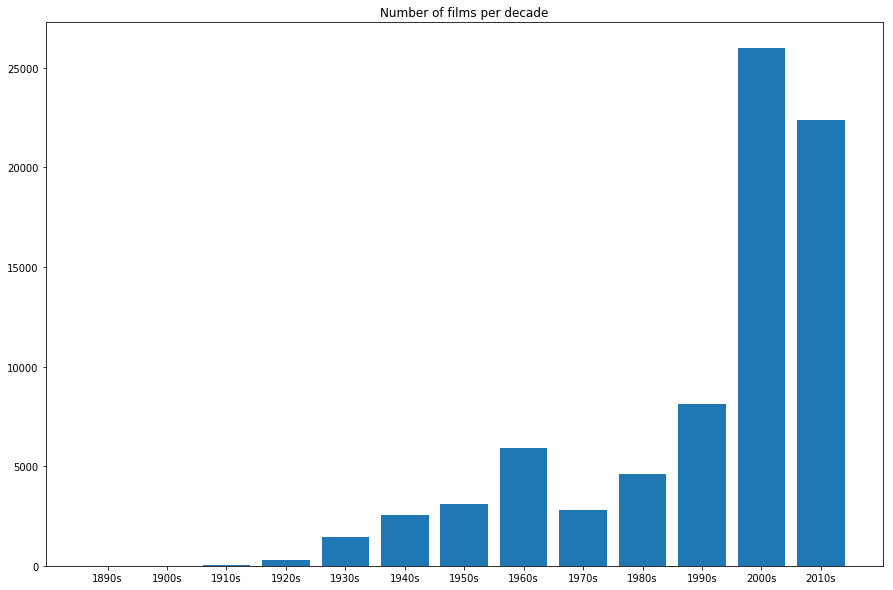

In [11]:
plt.figure(figsize=(15,10))
plt.bar(labels, counts)
plt.title('Number of films per decade')
plt.show()

As expected, we have more films in the recent decades. We can see from the plot above that the amount of data from the 1900s and 1910s decades are very low. Let's have a look at the exact number:

In [12]:
regex1900 = "190[0-9]"
regex1890 = "189[0-9]"
print("Number of movies from 1890s: {}".format(movies.filter(movies["year"].rlike(regex1890)).count()))
print("Number of movies from 1900s: {}".format(movies.filter(movies["year"].rlike(regex1900)).count()))

Number of movies from 1890s: 1
Number of movies from 1900s: 4


No meaningful analysis about the 1890s and 1900s can be done with so few data points, we will therefore drop these entries from the data set.

In [13]:
movies = movies.filter((movies["year"].rlike(regex1890) == False))
movies = movies.filter((movies["year"].rlike(regex1900) == False))

### 1.1.2 Median number of sentences by year

Our project is about evolution of language used in films, so let's have a peek at how and did it change over time. We will start by showing the median number of sentences for each year. We use median instead of mean since it's a more robust measure so in the case we have some invalid data (like unfinished movie subtitles with just a few sentences) it will behave better.

In [14]:
# get median number of sentences per year
percentile = F.expr('percentile_approx(sentences, 0.5)')
sdf_ = movies.groupby('year').agg(percentile.alias('n_sent_median'))

# convert to Pandas for plotting
sdf = sdf_.toPandas()

# sort the films by year
sdf = sdf.sort_values(by='year')

# convert year to int the 'year' value
sdf['year'] = pd.to_numeric(sdf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
sdf = sdf.dropna()
sdf = sdf.reset_index(drop=True)
sdf['year'] = sdf['year'].astype('int')

We will now visualize the median number of sentences by decade. For each decade, we will take the average of medians for that decade. We will ignore year 2020 (for all decades to have exactly 10 years).

In [15]:
years = list(sdf['year'])
labels = []
medians = []

for decade in range(1910, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(sdf.loc[sdf['year'] == year]['n_sent_median'])
            count += 1
    medians.append(median / count)

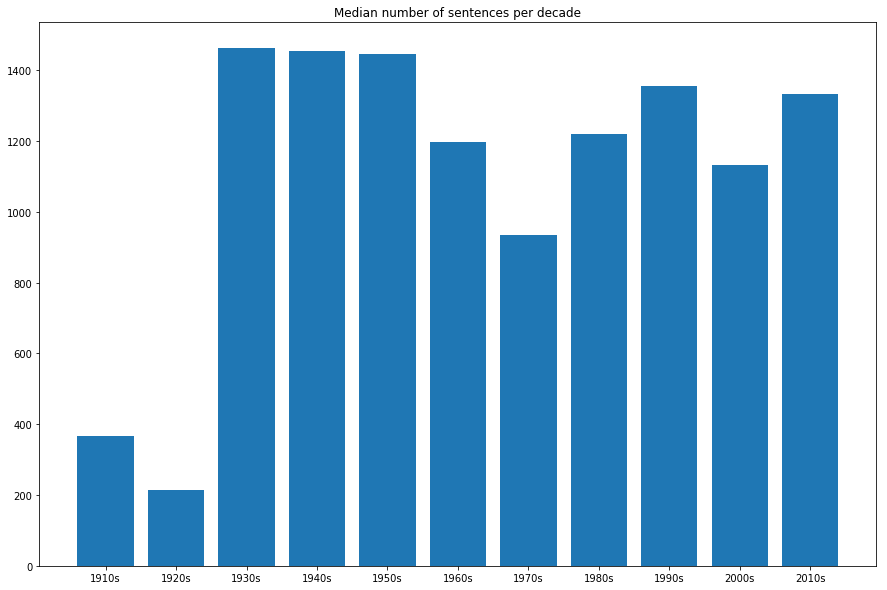

In [16]:
plt.figure(figsize=(15,10))
plt.bar(labels, medians)
plt.title('Median number of sentences per decade')
plt.show()

On this graph we can see some interesting things. Before 1930s, in the era of the silent films, there is a low number of sentences for each movie. In the 30s, the first decade of the "sound era", the number gets much larger: the movies have proper dialogue now. In the later decades, it seems the number has lowered a bit, but it didn't change much and is mostly around 1000 to 1400 senences per film.

### 1.1.3 Median number of words in sentences by year

We already checked sentences, but they can hide something. The number of words is also important. A movie can have many sentences but most of them can be very short. So let's check the median number of words per year and visualize it.

In [17]:
# get median number of words per year
percentile = F.expr('percentile_approx(words, 0.5)')
wdf_ = movies.groupby('year').agg(percentile.alias('n_word_median'))

# convert to Pandas for plotting
wdf = wdf_.toPandas()

# sort the films by year
wdf = wdf.sort_values(by='year')

# convert year to int the 'year' value
wdf['year'] = pd.to_numeric(wdf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
wdf = wdf.dropna()
wdf = wdf.reset_index(drop=True)
wdf['year'] = wdf['year'].astype('int')

In [18]:
years = list(wdf['year'])
labels = []
medians = []

for decade in range(1910, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(wdf.loc[wdf['year'] == year]['n_word_median'])
            count += 1
    medians.append(median / count)

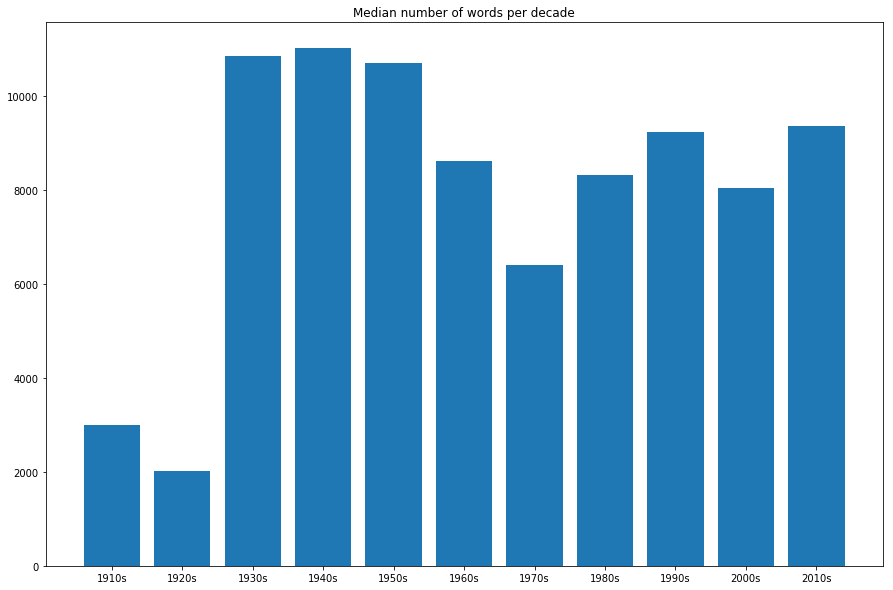

In [19]:
plt.figure(figsize=(15,10))
plt.bar(labels, medians)
plt.title('Median number of words per decade')
plt.show()

The graph seems very similar to the sentences graph in the previous section. So we can assume that number of words for each sentence did not really change.

### 1.1.4 Median film duration by year

Looking at the number of sentences per year we noticed that there is a smaller number of sentences in films in recent decades. However, could it be just because films were longer in the past? 

We will check the median film duration for every year. Again, we will visualize it in decades, taking the average of the median for each year of the decade. 

In [20]:
# get median duration per year
percentile = F.expr('percentile_approx(duration, 0.5)')
ddf_ = movies.groupby('year').agg(percentile.alias('duration_median'))

# convert to Pandas for plotting
ddf = ddf_.toPandas()

# sort the films by year
ddf = ddf.sort_values(by='year')

# convert year to int the 'year' value
ddf['year'] = pd.to_numeric(ddf['year'], errors='coerce', downcast='integer')

# remove films with "Nan" as year value
# since we cannot really use them
ddf = ddf.dropna()
ddf = ddf.reset_index(drop=True)
ddf['year'] = ddf['year'].astype('int')

In [21]:
years = list(ddf['year'])
labels = []
medians = []

for decade in range(1910, 2020, 10):
    # create bin label
    label = str(decade) + "s"
    labels.append(label)
    
    # calculate count for the bin
    median = 0
    count = 0
    for year in range(decade, decade+10):
        if year in years:
            median += int(ddf.loc[wdf['year'] == year]['duration_median'])
            count += 1
    medians.append(median / count)

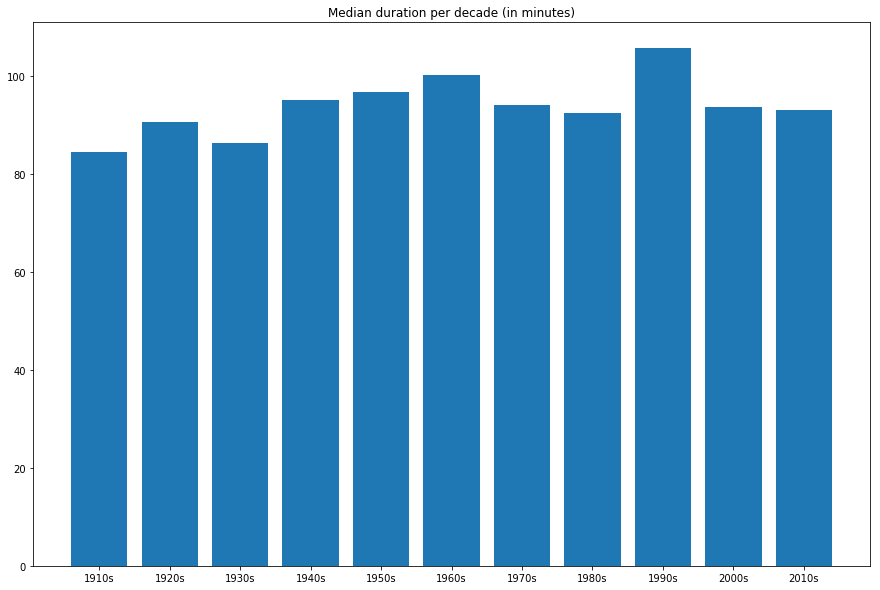

In [22]:
plt.figure(figsize=(15,10))
plt.bar(labels, medians)
plt.title('Median duration per decade (in minutes)')
plt.show()

As can be seen, the duration of the films did not really change by the years. The median duration is always around 80 to 100 minutes, even in the silent film era.

### 1.1.5 Distribution of genres

We are going to see what is the distribution of genres in our dataset.

In [23]:
# make genre column into a list of genres
movies_ = movies.withColumn("genre", F.split(movies.genre, ','))

# make a row for each genre
movies_ = movies_.withColumn("genre", F.explode("genre"))

# get count of each genre
genres_ = movies_.groupby('genre').count()

# convert to Pandas for plotting
genres = genres_.toPandas()

print("We have " + str(len(genres)) + " genres.")

We have 42 genres.


For visualization, we are going to remove the genres with a low count (which have less than 1000 entries).

Also, we are going to sort them by count.

In [24]:
genres = genres.query("count > 1000")
genres = genres.sort_values(by='count')

Let's plot the distribution of genres as a pie chart.

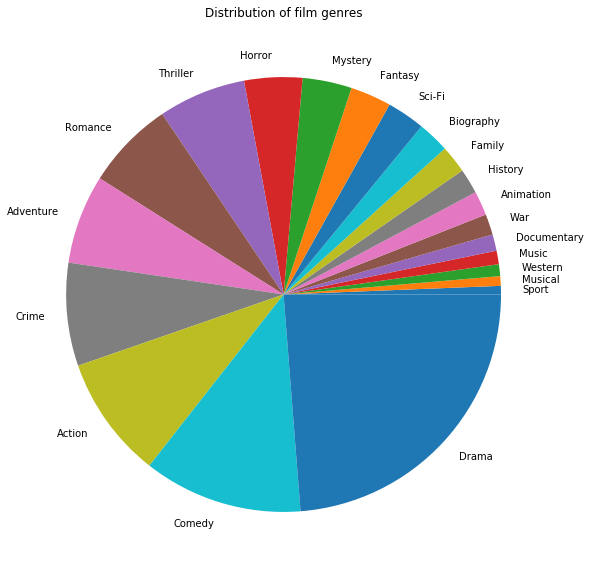

In [25]:
plt.figure(figsize=(10,10))
plt.pie(genres['count'], labels=genres['genre'])
plt.title('Distribution of film genres')
plt.show()

### 1.1.5 Distribution of IMDB ratings

Let's start by filtering out all movies which we don't have an IMDB rating 

In [26]:
movies_with_rating = movies.filter(F.col("averageRating").isNotNull())

How large porportion of the movies in our dataset contains IMDB ratings?

In [27]:
number_of_movies_with_ratings = movies_with_rating.count()
number_of_movies = movies.count()
print(round(number_of_movies_with_ratings / number_of_movies, 3))

0.994


We have ratings for close to all of the movies in our dataset, great!

Let's have a look at the distribution of imdb ratings:

In [28]:
movies_with_ratings_pandas = movies_with_rating.toPandas()
movies_with_ratings_pandas['numVotes'] = movies_with_ratings_pandas['numVotes'].astype(int)
movies_with_ratings_pandas['averageRating'] = movies_with_ratings_pandas['averageRating'].astype(float)

Text(0.5, 0, 'IMDB rating')

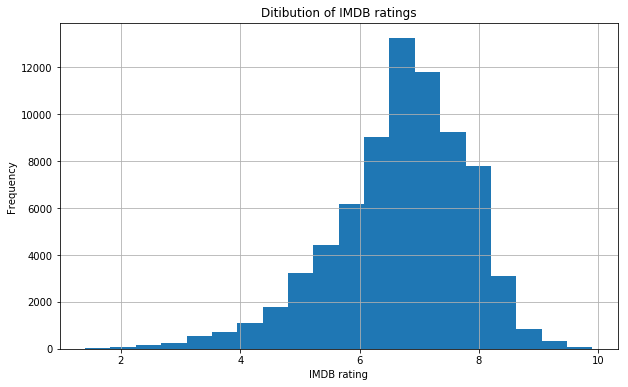

In [31]:
ax = movies_with_ratings_pandas['averageRating']\
    .plot\
    .hist(title="Ditibution of IMDB ratings", grid=True, figsize=(10,6), bins=20)
ax.set_xlabel("IMDB rating")

Judging from the above plot, it appears that the imdb ratings follow a normal distribution with a slight tail to the left and a mean of around ~7.

### 1.1.5 Mean film rating by decade

Let's first start with dropping rows which contain null values in the year column.

In [151]:
movies_with_ratings_pandas = movies_with_ratings_pandas.dropna(subset=['year'])

We bin our movies into decades by rounding the year column to the closest decade.

In [152]:
movies_with_ratings_pandas['decade'] = (movies_with_ratings_pandas['year'] - (movies_with_ratings_pandas['year'] % 10)).astype(int)

In order to get the mean of each decade, we group by the decade column and aggregate by taking the mean.

In [153]:
decade_imdb_mean = movies_with_ratings_pandas\
    .groupby('decade')\
    .mean()['averageRating']
decade_imdb_mean.index = decade_imdb_mean.index.astype(str) + "s"

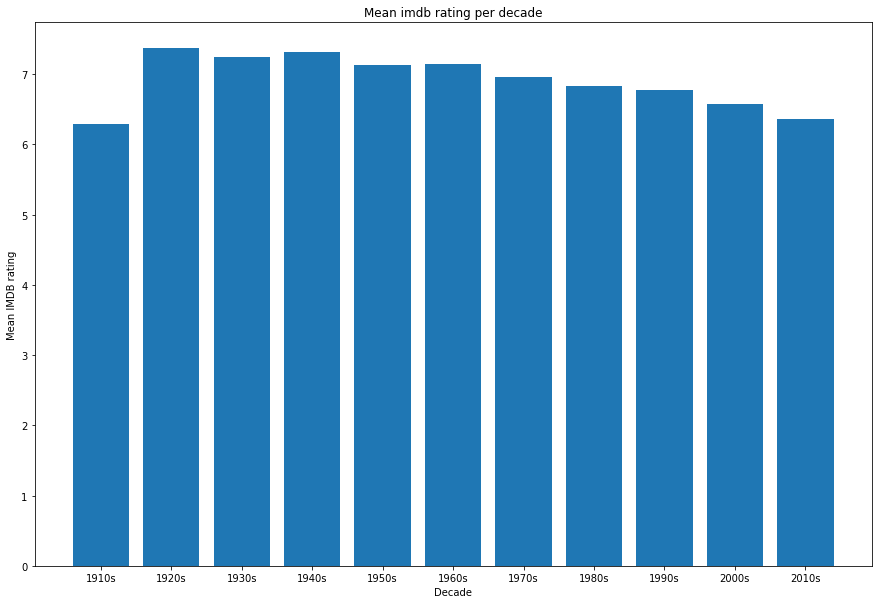

In [154]:
plt.figure(figsize=(15,10))
ax = plt.bar(decade_imdb_mean.index, decade_imdb_mean)
plt.title('Mean imdb rating per decade')
plt.xlabel('Decade')
plt.ylabel('Mean IMDB rating')
plt.show()

There are two key observations in the above plot:

1. The mean imdb rating has a peak around 1920-1940s.
2. The mean imdb rating has slowly but consistently decreased after the 1960s until today

## 1.2 Subtitle dataframe

Let's start by importing the dataframe and printing its schema.

In [7]:
subtitle_df = spark.read.parquet("./movie_subtitle_final.parquet")

In [2]:
subtitle_df.schema

StructType(List(StructField(_id,IntegerType,true),StructField(sentence,ArrayType(StructType(List(StructField(_VALUE,StringType,true))),true),true),StructField(sentence_length,IntegerType,true)))

Let's count the total amount of sentences we have in our dataframe:

In [4]:
print("Total amount of sentences: {}".format(subtitle_df.count()))

Total amount of sentences: 173562323


Let's continue by counting the total amount of words. Since each sentence is saved as an array of words, we can easily calculate the sentence length by computing the length of each sentence array and if we later sum over this column we will get the total amount of words in the dataframe.

In [5]:
# Create column with sentence length
subtitle_df = subtitle_df.withColumn('sentence_length',F.size(F.col('sentence')))

# Sum all sentence lenegths to get total amount of words
total_amount_of_words = subtitle_df.groupBy().sum().collect()

In [6]:
print("Total amount of words: {}".format(total_amount_of_words[0][1]))

Total amount of words: 1276487337


As can be observed in the above printouts, we are dealing with a lot of text. However, it's important to note that not all words will be used in the analysis. We will elaborate more on this below in the **Preprocessing** section.

# 2. Preprocessing 

Before starting the text analysis, we will do some preprocessing steps in order to transform the subtitle texts to a more suitable format and remove undesirable parts. 

As previously mentioned in the parsing section, sentences are stored as lists of strings. For instance the sentence "You're a lovely person." would be represented by the following list:
`["You", "'re", "a", "lovely", "person", "."]`.


There are a few types of words that we do not desire to be part of the analysis, we want to remove common words that do not add any value or meaning to the text. One such category is stop words (https://en.wikipedia.org/wiki/Stop_words). 

We also do not care about the punctuations (https://en.wikipedia.org/wiki/Punctuation) hence we will remove those as well.  

Finally, we also want to transform each word into its "base" form. For instance, the words take, took and taken should be treated as a single word in the analysis and not as three different ones. We will use Lemmatisation (https://en.wikipedia.org/wiki/Lemmatisation) in order to turn "took" and "taken" into their verb base form which is "take". However, we do not only want to lemmatize words but also other cases such as transforming plural words into singular and remove the -ing part of words (walking -> walk) etc.

Note from the above example sentence that contracted words (https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions) are represented as two words in the sentence list. This makes sence when calculating the length of each sentence since a contracted word is actually two words. However, the part on the right hande side of the apostrophe in the contracted word does not add any value to our analysis. Therefore we will drop any word which starts with an apostrophe. 

Finally, we also want to transform each word into lower case. We want the words "Take" and "take" to be treated as the same word.

To summerize, we are doing the folloing preprocessing steps of our subtitle data:

1. Transform each word into lower case 
2. Remove stop words
3. Remove punctuation 
4. Lemmatize words
5. Remove words which starts with an apostrophe

Let's perform the 5 steps described above!

In [8]:
subtitle_df = spark.read.parquet("./movie_subtitle_final.parquet")
# Filter empty sentences
subtitle_df = subtitle_df.filter(F.size(F.col('sentence._VALUE')) > 0)
subtitle_df.show(3)

+-------+--------------------+---------------+
|    _id|            sentence|sentence_length|
+-------+--------------------+---------------+
|5131043|[[They], ['re], [...|              4|
|5131043|[[they], ['re], [...|              4|
|5131043|[[they], ['re], [...|              8|
+-------+--------------------+---------------+
only showing top 3 rows



**(1)** Let's convert each word into its lower case representation:

In [9]:
toLowerSentence = F.udf(lambda x: list(map(lambda y: y.lower() if y != None else y, x)), ArrayType(StringType()))
subtitle_df = subtitle_df.select('_id', 
                                 toLowerSentence('sentence._VALUE').alias('sentence'), 
                                 F.col('sentence_length').alias('original_sentence_length'))
subtitle_df.show(3)

+-------+--------------------+------------------------+
|    _id|            sentence|original_sentence_length|
+-------+--------------------+------------------------+
|5131043|[they, 're, indep...|                       4|
|5131043|[they, 're, affec...|                       4|
|5131043|[they, 're, loyal...|                       8|
+-------+--------------------+------------------------+
only showing top 3 rows



**(2)** We will take help from the NLTK library(https://www.nltk.org/) to filter out stop words. NLTK provides predefined lists of stop words for several different languages, we will use the list for the english language. 

In [10]:
stop_words=set(stopwords.words('english'))
wordInStopWords = F.udf(lambda x: list(filter(lambda y: y not in stop_words,x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', wordInStopWords('sentence').alias('sentence'), 'original_sentence_length')
subtitle_df.show(3)

+-------+--------------------+------------------------+
|    _id|            sentence|original_sentence_length|
+-------+--------------------+------------------------+
|5131043|['re, independent...|                       4|
|5131043|['re, affectionat...|                       4|
|5131043|['re, loyal, ;, '...|                       8|
+-------+--------------------+------------------------+
only showing top 3 rows



**(3)** To filter out punctuations, we can use the built in puncuation list contained in the string class of Python.

In [11]:
punctuation_list=list(string.punctuation)
remvovePunctuation = F.udf(lambda x: list(filter(lambda y: y not in punctuation_list,x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', remvovePunctuation('sentence').alias('sentence'), 'original_sentence_length')
subtitle_df.show(3)

+-------+--------------------+------------------------+
|    _id|            sentence|original_sentence_length|
+-------+--------------------+------------------------+
|5131043|  ['re, independent]|                       4|
|5131043| ['re, affectionate]|                       4|
|5131043|['re, loyal, 're,...|                       8|
+-------+--------------------+------------------------+
only showing top 3 rows



**(4)** The NLTK library provies a lemmatizer API.

In [ ]:
lemmatizer = WordNetLemmatizer()
lemmatize = F.udf(lambda x: lemmatizer.lemmatize(x, 'v'), StringType())
subtitle_df = subtitle_df.select('_id', lemmatize(F.col('word')).alias('word'), 'original_sentence_length')

**(5)** Remove words starting with an apostrophe

In [12]:
removeApostopheWords = F.udf(lambda x: list(filter(lambda y: y[0] != "'",x)), ArrayType(StringType()))
subtitle_df = subtitle_df\
                    .select('_id', removeApostopheWords('sentence').alias('sentence'), 'original_sentence_length')
subtitle_df.show(3)

+-------+------------------+------------------------+
|    _id|          sentence|original_sentence_length|
+-------+------------------+------------------------+
|5131043|     [independent]|                       4|
|5131043|    [affectionate]|                       4|
|5131043|[loyal, beautiful]|                       8|
+-------+------------------+------------------------+
only showing top 3 rows



Let's have a look on the poportion of words that has been filtered out during the above steps:

In [13]:
subtitle_df = subtitle_df.withColumn('sentence_length_after_filtering',F.size(F.col('sentence')))
total_amount_of_words = subtitle_df.groupBy().sum().collect()
total_amount_of_words

[Row(sum(_id)=15380688203805207, sum(original_sentence_length)=1276487464, sum(sentence_length_after_filtering)=468131830)]

In [14]:
print("Total amount of words before filtering: {}".format(total_amount_of_words[0][1]))
print("Total amount of words after filtering: {}".format(total_amount_of_words[0][2]))
print("Percentage of original size: {}".format(round(total_amount_of_words[0][2]/total_amount_of_words[0][1], 3)))

Total amount of words before filtering: 1276487464
Total amount of words after filtering: 468131830
Percentage of original size: 0.367


After removing punctuations and stop words we are only left with roughly a third of the words of the original dataset. 



## <font color='red'> (Plan for milestone 3 below)</font>


# 3. Text analysis 

## 3.1 Text complexity analysis

### 3.1.1 Quantification of text complexity

In this subsection we will choose and implement a method for getting a measure of textual complexity. 

The measure we are going to use is the Dale-Challe readability forumla, as described here:
https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula

We might also also try other qantification complexity ideas:
* https://www.geeksforgeeks.org/readability-index-pythonnlp/
* calculate the number of syllabuses in each word https://www.howmanysyllables.com/whataresyllables

### 3.1.2 Comparison of text complexity by year

In this subsection we are going to compare the complexity of the movie language for each year.
We want to see if the complexity differs across years.

To do this, we are going to calculate the text complexity measure for each film, and then take the average of complexity for each year.

### 3.1.3 Comparison of text complexity by genre

In this subsection we are going to compare the complexity of the movie language for each genre.
Do some genres use more simple language than others?

To do this, we are going to calculate the text complexity measure for each film, and then take the average of complexity for each genre.

## 3.2 Sentimental analysis

In this section we are going to perform sentimental analysis on the subtitle text. 

The aim of this section is to explore if movies express more or less positive emotion nowdays compared to back in the day. We also plan to explore how this property differ between genres. We plan to calculate the polarity of the text of each film with the help of textblob (https://textblob.readthedocs.io/en/dev/index.html). 

## 3.3 Offensive language analysis

In this section we are going to analyize the use of offensive/swear words in subtitle text. 

We will use resources such as offensive word lexicons (https://www.cs.cmu.edu/~biglou/resources/) to quantify the level of offensivity of a certain film. Then, we are going to check the level of offensivity in relation to years (are films more/less offensive now) and genres (do some genres use more offensive words)

## 3.4 Correlation between text properties and IMDB rating

In this section we are going to search for correlation between the film textual properties obtained in sections 3.1, 3.2 and 3.3 and its IMDB rating.

To do this we are going to use correlation coefs and visualization to find evidence for correlation between the text properties of a movie and its rating. 

If we find evidence for correlation, we will try some regression methods on the two variables, such as fitting a regression line.